In [6]:
%matplotlib inline
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from prettyplots.prettyplots import percentiles_to_errors
from astropy.convolution import Gaussian2DKernel, convolve_fft
import numpy as np
plt.style.use('paper')

In [32]:
def get_stats(samples, idx1='pa_deg', idx2='inc_deg', kernel=2, bins=None):
    """Get the convolved stats."""

    # Default binning.
    bins = [np.linspace(samples[idx1].min(), samples[idx1].max(), 101),
            np.linspace(samples[idx2].min(), samples[idx2].max(), 101)] if bins is None else bins

    # Calculate the histogram.
    H, xe, ye = np.histogram2d(samples[idx1], samples[idx2], bins=bins, normed=True)
    x = np.average([xe[1:], xe[:-1]], axis=0)
    y = np.average([ye[1:], ye[:-1]], axis=0)
    H = convolve_fft(H, Gaussian2DKernel(x_stddev=kernel))
    
    
    # Make the marginalized values.
    Hx = np.sum(H, axis=1)
    Hx /= np.trapz(Hx, x)
    Hy = np.sum(H, axis=0)
    Hy /= np.trapz(Hy, y)
    
    
    # Calculating the proper contour levels for a PDF.
    # Stripped from DFM's corner.py.
    # Note: may hang up with incorrect indexing.
    if 1:
        levels = 1.0 - np.exp(-0.5 * np.arange(0.5, 2.1, 0.5)**2)
        Hflat = H.flatten()
        inds = np.argsort(Hflat)[::-1]
        Hflat = Hflat[inds]
        sm = np.cumsum(Hflat)
        sm /= sm[-1]
        V = np.empty(len(levels))
        for i, v0 in enumerate(levels):
            try:
                V[i] = Hflat[sm <= v0][-1]
            except:
                V[i] = Hflat[0]
        V.sort()
        m = np.diff(V) == 0
        while np.any(m) and np.sum(H) > 0.0:
            V[np.where(m)[0][0]] *= 1.0 - 1e-4
            m = np.diff(V) == 0
        V.sort()

    return x, y, H.T, Hx, Hy, V

In [33]:
samples_345 = pd.read_pickle('../mcmc/TWHya.345GHz.circ.150000.trace.dat')
#samples_290 = pd.read_pickle('../mcmc/TWHya.290GHz.circ.150000.trace.dat')
samples_230 = pd.read_pickle('../mcmc/TWHya.230GHz.circ.150000.trace.dat')

for sample in [samples_345, samples_230]:
    #sample['inc'] = np.degrees(sample['inc'])
    print(percentiles_to_errors(np.percentile(sample['inc_deg'], [16, 50, 84])))
    print(percentiles_to_errors(np.percentile(sample['pa_deg'], [16, 50, 84])))
    print()

[5.27642552 0.11092995 0.10707012]
[1.51384554e+02 2.99438753e-02 2.99251745e-02]

[6.53466917 0.06630254 0.06605378]
[1.51366015e+02 2.99232159e-02 2.98979349e-02]



/Users/rteague/.conda/envs/py35/lib/python3.5/site-packages/astropy/convolution/convolve.py:670: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
/Users/rteague/.conda/envs/py35/lib/python3.5/site-packages/astropy/convolution/convolve.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = normalized_kernel
/Users/rteague/.conda/envs/py35/lib/python3.5/site-packages/astropy/convolution/convolve.py:692: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

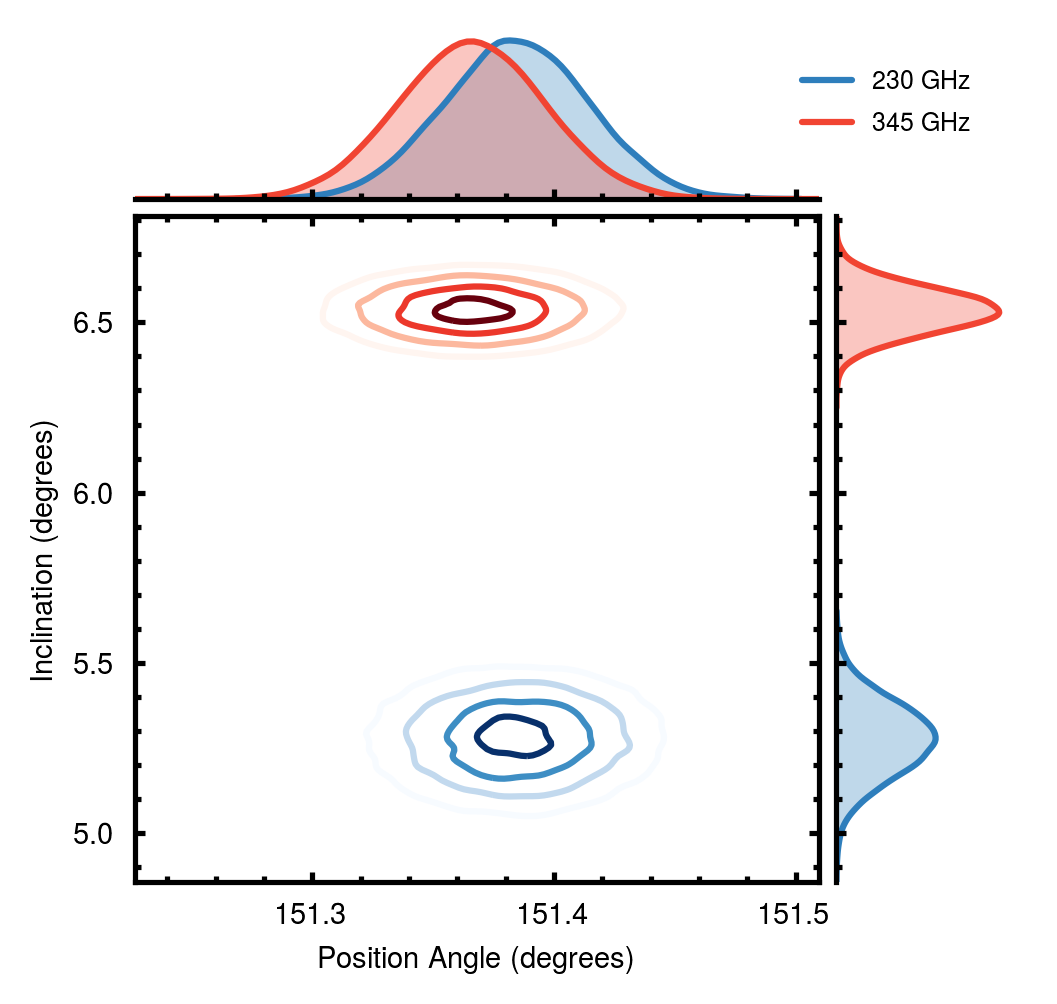

In [34]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(3.75, 3.75),
                        gridspec_kw={'height_ratios': [1, 4],
                                     'width_ratios': [4, 1],
                                     'wspace': 0.04, 'hspace': 0.04})
axs[0, 1].axis('off')
ax = axs[1, 0]

cmap = cm.Blues
x, y, H, Hx, Hy, V = get_stats(samples_345)
ax.contour(x, y, H, V, cmap=cmap)
axs[0, 0].plot(x, Hx, color=cmap(0.7))
axs[0, 0].fill_between(x, Hx, color=cmap(0.7), alpha=0.3, lw=0.0, zorder=-1)
axs[1, 1].plot(Hy, y, color=cmap(0.7))
axs[1, 1].fill_betweenx(y, Hy, color=cmap(0.7), alpha=0.3, lw=0.0, zorder=-1)


if 0:
    cmap = cm.Greys
    x, y, H, Hx, Hy, V = get_stats(samples_290)
    ax.contour(x, y, H, V, cmap=cmap)
    axs[0, 0].plot(x, Hx, color=cmap(0.4))
    axs[0, 0].fill_between(x, Hx, color=cmap(0.4), alpha=0.3, lw=0.0, zorder=-1)
    axs[1, 1].plot(Hy, y, color=cmap(0.4))
    axs[1, 1].fill_betweenx(y, Hy, color=cmap(0.4), alpha=0.3, lw=0.0, zorder=-1)


cmap = cm.Reds
x, y, H, Hx, Hy, V = get_stats(samples_230)
ax.contour(x, y, H, V, cmap=cmap)
axs[0, 0].plot(x, Hx, color=cmap(0.6))
axs[0, 0].fill_between(x, Hx, color=cmap(0.6), alpha=0.3, lw=0.0, zorder=-1)
axs[1, 1].plot(Hy, y, color=cmap(0.6))
axs[1, 1].fill_betweenx(y, Hy, color=cmap(0.6), alpha=0.3, lw=0.0, zorder=-1)


ax.tick_params(which='both', right=1, top=1)
axs[0, 0].set_xticklabels([])
axs[1, 1].set_yticklabels([])
axs[0, 0].set_ylim(0, axs[0, 0].get_ylim()[1])
axs[0, 0].set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])
axs[1, 1].set_xlim(0, axs[1, 1].get_xlim()[1])
axs[0, 0].spines['top'].set_visible(False)
axs[0, 0].spines['left'].set_visible(False)
axs[0, 0].spines['right'].set_visible(False)
axs[0, 0].set_yticks([])

axs[1, 1].set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])
axs[1, 1].spines['top'].set_visible(False)
axs[1, 1].spines['bottom'].set_visible(False)
axs[1, 1].spines['right'].set_visible(False)
axs[1, 1].set_xticks([])

axs[1, 1].yaxis.set_major_locator(MultipleLocator(0.5))
axs[1, 0].yaxis.set_major_locator(MultipleLocator(0.5))
axs[0, 0].xaxis.set_major_locator(MultipleLocator(0.1))
axs[1, 0].xaxis.set_major_locator(MultipleLocator(0.1))

ax.set_xlabel('Position Angle (degrees)')
ax.set_ylabel('Inclination (degrees)')

axs[0, 1].plot([np.nan], [np.nan], color=cm.Blues(0.7), label='230 GHz')
#axs[0, 1].plot([np.nan], [np.nan], color=cm.Greys(0.4), label='290 GHz')
axs[0, 1].plot([np.nan], [np.nan], color=cm.Reds(0.6), label='345 GHz')
axs[0, 1].legend(markerfirst=True, fontsize=6)

#plt.savefig('inferred_geometry.PAprior.pdf', bbox_inches='tight')